In [1]:
# Install gdown to handle Google Drive downloads comfortably
!pip install gdown -q

import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Visualization Setup
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries installed and imported.")

Libraries installed and imported.


In [2]:
# 1. Download the file directly from your Google Drive link
file_id = '1Mfi4InZjUUPxW6QJnYXM18kYrhdOIcgk'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'games.csv'
gdown.download(url, output, quiet=False)

# 2. Load Data
df = pd.read_csv('games.csv')

# 3. Clean Data (Same steps as Notebook 1)
# Remove draws
df = df[df['winner'] != 'draw']

# 4. Feature Engineering
# Create Rating Difference
df['rating_difference'] = df['white_rating'] - df['black_rating']

# Parse Time Control (e.g., "15+2")
split_time = df['increment_code'].str.split('+', expand=True)
df['base_time'] = split_time[0].astype(int)
df['increment'] = split_time[1].astype(int)

# Encode Target (White=1, Black=0)
df['target'] = df['winner'].apply(lambda x: 1 if x == 'white' else 0)

print(f"\nData successfully loaded and cleaned. Shape: {df.shape}")
display(df[['white_rating', 'black_rating', 'rating_difference', 'target']].head())

Downloading...
From: https://drive.google.com/uc?id=1Mfi4InZjUUPxW6QJnYXM18kYrhdOIcgk
To: /content/games.csv
100%|██████████| 7.67M/7.67M [00:00<00:00, 17.9MB/s]



Data successfully loaded and cleaned. Shape: (19108, 20)


,white_rating,black_rating,rating_difference,target
0,1500,1191,309,1
1,1322,1261,61,0
2,1496,1500,-4,1
3,1439,1454,-15,1
4,1523,1469,54,1


In [3]:
# Select Features
# We use ratings and time controls.
# 'rating_difference' is likely the strongest predictor.
feature_cols = ['white_rating', 'black_rating', 'rating_difference', 'base_time', 'increment']

X = df[feature_cols]
y = df['target']

print("Features selected:")
print(feature_cols)

Features selected:
['white_rating', 'black_rating', 'rating_difference', 'base_time', 'increment']


In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} games")
print(f"Testing set size: {X_test.shape[0]} games")

Training set size: 15286 games
Testing set size: 3822 games


In [5]:
# Initialize Scaler
scaler = StandardScaler()

# Fit on training data, transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for readability (optional but helpful)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols)

print("Data scaled successfully.")
display(X_train_scaled.head())

Data scaled successfully.


,white_rating,black_rating,rating_difference,base_time,increment
0,1.629337,1.213463,0.484926,-0.220525,-0.369709
1,-0.671312,-1.176191,0.585302,0.080280,-0.297474
2,-0.740401,2.257857,-3.481935,-0.220525,-0.369709
3,-0.992574,-0.681661,-0.362248,-0.401009,0.280405
4,0.869362,1.351794,-0.558985,0.080280,0.352640


In [6]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
baseline_acc = dummy.score(X_test, y_test)

print(f"Baseline Accuracy (Guessing the most common winner): {baseline_acc:.2%}")

Baseline Accuracy (Guessing the most common winner): 52.07%


In [7]:
# Initialize and Train
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Predict
y_pred_log = log_reg.predict(X_test_scaled)

# Evaluate
log_acc = accuracy_score(y_test, y_pred_log)
print(f"Logistic Regression Accuracy: {log_acc:.2%}")

Logistic Regression Accuracy: 65.02%


In [8]:
# Initialize and Train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train) # Tree models don't strictly need scaling, but it's fine if we use it

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_acc:.2%}")

Random Forest Accuracy: 65.54%


Baseline: 52.07%
Logistic Regression: 65.02%
Random Forest: 65.54%


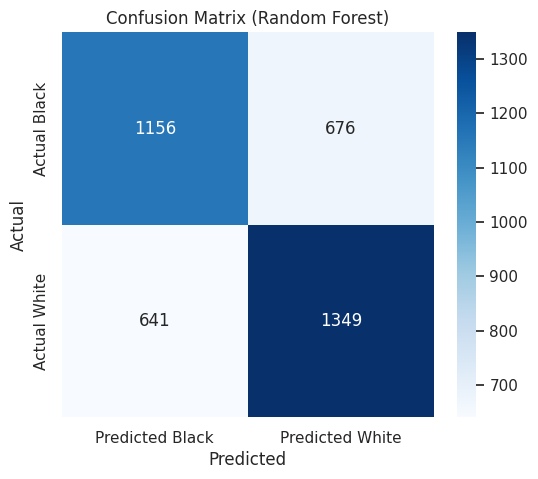


--- Classification Report ---
              precision    recall  f1-score   support

       Black       0.64      0.63      0.64      1832
       White       0.67      0.68      0.67      1990

    accuracy                           0.66      3822
   macro avg       0.65      0.65      0.65      3822
weighted avg       0.66      0.66      0.66      3822



In [9]:
# Compare Models
print(f"Baseline: {baseline_acc:.2%}")
print(f"Logistic Regression: {log_acc:.2%}")
print(f"Random Forest: {rf_acc:.2%}")

# Confusion Matrix for the Best Model (likely Random Forest)
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Black', 'Predicted White'],
            yticklabels=['Actual Black', 'Actual White'])
plt.title('Confusion Matrix (Random Forest)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_rf, target_names=['Black', 'White']))

/tmp/ipython-input-3097058781.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=[feature_cols[i] for i in indices], palette='viridis')


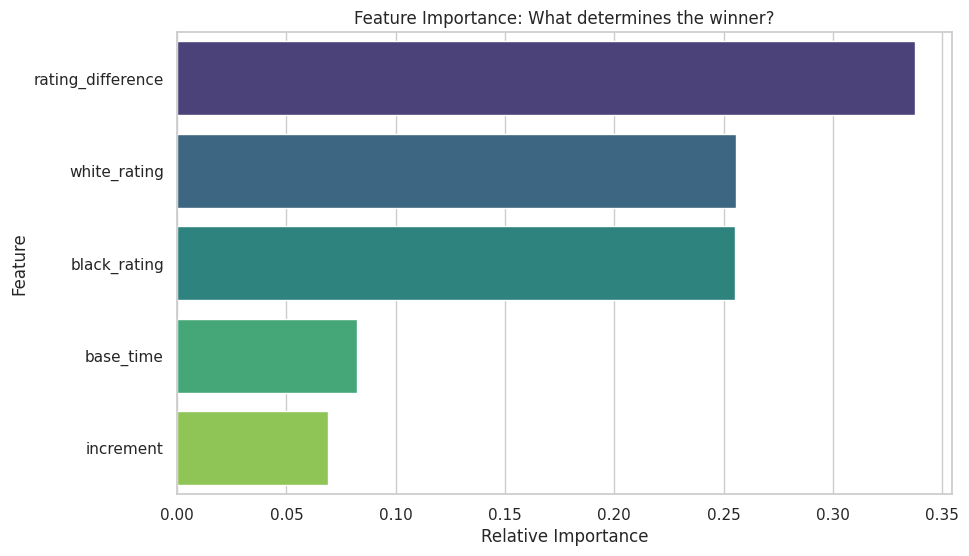

Interpretation: The 'rating_difference' should be the top bar, indicating it is the strongest predictor.


In [10]:
# Get feature importances from Random Forest
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=[feature_cols[i] for i in indices], palette='viridis')
plt.title('Feature Importance: What determines the winner?')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.show()

print("Interpretation: The 'rating_difference' should be the top bar, indicating it is the strongest predictor.")